## [LG 전자] 자연어 처리 # 2 : 분상 표상 기반의 임베딩 기법
* Word2Vec
* GloVe
* FastText

예상 난이도 ⭐️

## 실습 요약
* 분상표상 기반의 임베딩 기법을 학습합니다
* 여러가지 임베딩 기법을 통해 간단한 모델을 구축한 후 성능을 비교합니다

------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [ ]:
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

In [ ]:
! pip install konlpy -q
! pip install glove_python_binary -q

In [ ]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)




In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/KU-DIC/LG_natural_language_processing_day21

In [ ]:
# 데이터셋 읽기
with open('./LG_natural_language_processing_day21/data/naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()

In [ ]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive, 
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(1) # positive
  else:
    label.append(-1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 652105.08it/s]


In [ ]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=42)

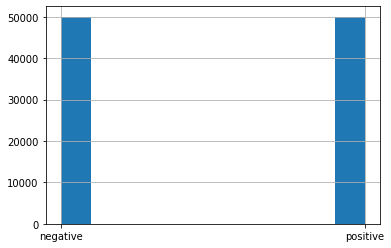

In [ ]:
df['label'].hist()

In [ ]:
df.head()

,rate,label,sentence
119737,2,negative,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,positive,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,positive,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~
65426,5,positive,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,positive,기타 남 멋지고 예뻐요 여러 사은품도 좋아요


### STEP 2. 데이터 전처리 (Preprocessing)

In [ ]:
review_sentences = df['sentence'].to_list()

In [ ]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
  text = re.sub('[ㅠㅎㅋ]','', text)
  return text

In [ ]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 225911.59it/s]


In [ ]:
df

,rate,label,sentence,normalize_sentence
119737,2,negative,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,positive,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,positive,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~,재구매 배송빨라요 길냥이들이 잘먹어요 대용량이라 좋네요
65426,5,positive,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,positive,기타 남 멋지고 예뻐요 여러 사은품도 좋아요,기타 남 멋지고 예뻐요 여러 사은품도 좋아요
...,...,...,...,...
7568,2,negative,전에쓰던 오일이 아니네요.ㅠ,전에쓰던 오일이 아니네요.
83772,2,negative,비닐 고정 똑딱이? 그부분 한번 사용했는데 바로 찢어지네요 깨진다는 표현이 맞나요 ...,비닐 고정 똑딱이 그부분 한번 사용했는데 바로 찢어지네요 깨진다는 표현이 맞나요 아...
118200,5,positive,덕분에 저렴한 가격으로 제작 했네요.,덕분에 저렴한 가격으로 제작 했네요.
153871,2,negative,커버가 질이 안좋아서 오래 못쓸것 같아요,커버가 질이 안좋아서 오래 못쓸것 같아요


### STEP 3. 토큰화 진행 (Tokenization)

In [ ]:
# Okt(Open Korea Text)
from konlpy.tag import Okt  
okt=Okt() 

okt.morphs(normalize_sentence[0])

In [ ]:
tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = okt.morphs(sent)
  tokenized_sentence.append(sent)

100%|██████████| 100000/100000 [06:59<00:00, 238.56it/s]


In [ ]:
df['tokenized_sentence'] = tokenized_sentence

In [ ]:
df.head()

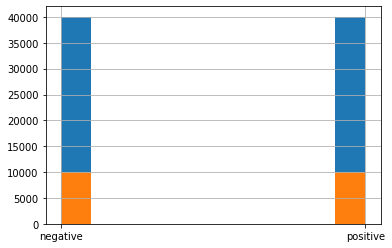

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
train_df['label'].hist()
test_df['label'].hist()

### STEP 4. 벡터화 진행 (Vectorization)

#### Method 1. Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
train_sentence = train_df['tokenized_sentence'].to_list()
test_sentence = test_df['tokenized_sentence'].to_list()

In [ ]:
%%time
model = Word2Vec(
    sentences=train_sentence,
    size=100, 
    window=5, 
    min_count=1, 
    workers=4,
    seed=random_seed)

CPU times: user 35.7 s, sys: 370 ms, total: 36 s
Wall time: 26.4 s


In [ ]:
model.build_vocab([['<UNK>']],update=True)

In [ ]:
# model.save("word2vec.model")

In [ ]:
vocab = list(model.wv.vocab)

In [ ]:
len(vocab),type(vocab)

(67654, list)

In [ ]:
model.wv.most_similar('별로', topn=10)

[('별루', 0.8738036751747131),
 ('부석해서', 0.7595747113227844),
 ('졀로', 0.7581014633178711),
 ('별루별루별루별루', 0.7471020221710205),
 ('섀도우', 0.7422731518745422),
 ('신의한수', 0.7378954887390137),
 ('뱔로', 0.7315418124198914),
 ('막무가내', 0.7220317721366882),
 ('소름', 0.7181041836738586),
 ('에러', 0.7118133902549744)]

In [ ]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [02:00<00:00, 165.32it/s]


In [ ]:
train_df['w2v_sentence_vector'] = train_sentence_vector
test_df['w2v_sentence_vector'] = test_sentence_vector

#### Method 2. Glove

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(train_sentence, window=5)
glove = Glove(no_components=100, learning_rate=0.05, random_state=42)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
glove.most_similar("별로",number=10)

[('에요', 0.9359565467561218),
 ('예요', 0.9044741251685323),
 ('임', 0.8953138297688558),
 ('별루', 0.8872834387651115),
 ('였어요', 0.8840304931563836),
 ('였네요', 0.8714731780423475),
 ('멸로멸류멸', 0.8450582105914648),
 ('붙지안음', 0.8243578207139584),
 ('너무해', 0.7983413734824351)]

In [ ]:
vocab = []
for word, word_idx in tqdm(glove.dictionary.items()):
  vocab.append(word)

100%|██████████| 67653/67653 [00:00<00:00, 1306535.27it/s]


In [ ]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += glove.word_vectors[glove.dictionary[word]]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += glove.word_vectors[glove.dictionary[word]]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [02:12<00:00, 151.27it/s]


In [ ]:
train_df['glove_sentence_vector'] = train_sentence_vector
test_df['glove_sentence_vector'] = test_sentence_vector

#### Method 3. FastText

In [ ]:
%%time
from gensim.models import FastText

model = FastText(
    sentences = tokenized_sentence,
    size=100,
    window=5,
    min_count=1,
    workers=4)

CPU times: user 1min 14s, sys: 908 ms, total: 1min 15s
Wall time: 52.6 s


In [ ]:
vocab = list(model.wv.vocab)

In [ ]:
len(vocab)

76908

In [ ]:
model.wv.most_similar('별로', topn=10)

[('별로넷', 0.9996068477630615),
 ('별루', 0.8530545830726624),
 ('닥별루', 0.8459689617156982),
 ('별루없', 0.8427098989486694),
 ('별루별루', 0.8366000652313232),
 ('별루여', 0.8299564719200134),
 ('별루다', 0.8254740238189697),
 ('별루료', 0.8250741958618164),
 ('별루별루별루', 0.8250157833099365),
 ('별루래', 0.8218951225280762)]

In [ ]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [01:26<00:00, 232.48it/s]


In [ ]:
train_df['ft_sentence_vector'] = train_sentence_vector
test_df['ft_sentence_vector'] = test_sentence_vector

In [ ]:
# train_df.to_csv('./train_df.csv')
# test_df.to_csv('./test_df.csv')

### STEP 5. 모델 구축하기 (Modeling)
* Word2Vec, Glove, FastText를 활용하여 감성분석 모델 만들기


#### Word2Vec을 사용하여 감성 분석하기

In [ ]:
w2v_df = train_df[['label','w2v_sentence_vector']]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

sent_vec = np.stack(w2v_df.w2v_sentence_vector,axis=0)
label_vec = np.array(w2v_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [ ]:
w2v_df = test_df[['label','w2v_sentence_vector']]
sent_vec = np.stack(w2v_df.w2v_sentence_vector,axis=0)
label_vec = np.array(w2v_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.76705

In [ ]:
glove_df = train_df[['label','glove_sentence_vector']]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)

sent_vec = np.stack(glove_df.glove_sentence_vector,axis=0)
label_vec = np.array(glove_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [ ]:
glove_df = test_df[['label','glove_sentence_vector']]

sent_vec = np.stack(glove_df.glove_sentence_vector,axis=0)
label_vec = np.array(glove_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.71695

In [ ]:
from sklearn.tree import DecisionTreeClassifier
ft_df = train_df[['label','ft_sentence_vector']]

model = DecisionTreeClassifier(random_state=42)

sent_vec = np.stack(ft_df.ft_sentence_vector,axis=0)
label_vec = np.array(ft_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [ ]:
ft_df = test_df[['label','ft_sentence_vector']]

sent_vec = np.stack(ft_df.ft_sentence_vector,axis=0)
label_vec = np.array(ft_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.751